# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

C:\Users\Phil\Anaconda3\envs\aind\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [2]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [3]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx  grnd-ly  
video frame                                      
98    0          113        9      -12      119  
      1          113        9      -12      119  
      2          113        9      -12      119  
      3          113        9      -12      119  
      4          113        9      -12      119

In [4]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [5]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['HIT', 'YESTERDAY', 'GET', 'HERE', 'BUT', 'GO', 'PARTY', 'TELL', 'TOMORROW', 'LAST-WEEK', 'CAN', 'TOY', 'TOY1', 'BREAK-DOWN', 'PUTASIDE', 'BILL', 'THINK', 'FIND', 'FUTURE', 'TEACHER', 'ARRIVE', 'POTATO', 'WHAT', 'GIVE3', 'OLD', 'PAST', 'JANA', 'WONT', 'CHINA', 'HOUSE', 'BUY1', 'NAME', 'KNOW', 'THROW', 'WILL', 'CHICAGO', 'HAVE', 'SELF', 'BUY', 'SAY-1P', 'BORROW', 'FRIEND', 'BLUE', 'NEXT-WEEK', 'GIVE2', 'BOX', 'CORN', 'GIVE', 'VEGETABLE', 'BLAME', 'STUDENT', 'READ', 'ALL', 'FRANK', 'WHO', 'WRITE', 'FISH', 'IX', 'NEW', 'FUTURE1', 'SHOULD', 'WOMAN', 'MARY', 'COAT', 'MAN', 'POSS', 'BROTHER', 'LIKE', 'NOT', 'MOTHER', 'SOMETHING-ONE', 'HOMEWORK', 'BOOK', 'IX-1P', 'LOVE', 'LEAVE', 'SHOOT', 'GIRL', 'DECIDE', 'GROUP', 'CHOCOLATE', 'WANT', 'CAR', 'SEE', 'PREFER', 'JOHN', 'VISIT', 'SEARCH-FOR', 'CORN1', 'BOY', 'SELL', 'FINISH', 'BROCCOLI', 'SAY', 'CANDY', 'SUE', 'CHICKEN', 'PEOPLE', 'MANY', 'NEW-YORK', 'LEG', 'STOLEN', 'EAT', 'MOVIE', 'GO2', 'ANN', 'LIVE', 'GIVE1', 'FRED', 'APPLE'

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [6]:
df_means = asl.df.groupby('speaker').mean()

To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [7]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx  grnd-ly  left-x-mean  
video frame                                                   
98    0          113        9      -12      119   164.661438  
      1          113        9      -12      119   164.661438  
      2          113        9      -12      119   164.661438  
      3          113        9      -12      119   164.661438  
      4          113        9      -12      119   164.661438

##### Try it!

In [8]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-lx,grnd-ly,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,15.080360,36.572749,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,17.328941,27.117393,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,15.050938,29.320655,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [10]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

asl.df['left-x-mean']  = asl.df['speaker'].map(df_means['left-x'])
asl.df['left-y-mean']  = asl.df['speaker'].map(df_means['left-y'])
asl.df['right-x-mean'] = asl.df['speaker'].map(df_means['right-x'])
asl.df['right-y-mean'] = asl.df['speaker'].map(df_means['right-y'])
asl.df['left-x-std']   = asl.df['speaker'].map(df_std['left-x'])
asl.df['left-y-std']   = asl.df['speaker'].map(df_std['left-y'])
asl.df['right-x-std']  = asl.df['speaker'].map(df_std['right-x'])
asl.df['right-y-std']  = asl.df['speaker'].map(df_std['right-y'])

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']
asl.df['norm-lx']= (asl.df['left-x']-asl.df['left-x-mean'])/asl.df['left-x-std']
asl.df['norm-ly']= (asl.df['left-y']-asl.df['left-y-mean'])/asl.df['left-y-std']
asl.df['norm-rx']= (asl.df['right-x']-asl.df['right-x-mean'])/asl.df['right-x-std']
asl.df['norm-ry']= (asl.df['right-y']-asl.df['right-y-mean'])/asl.df['right-y-std']

asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx    ...     right-x-mean  right-y-mean  \
video frame                               ...                                  
98    0          113        9      -12    ...       151.017865    117.332462   
      1          113        9      -12    ...       151.017865    117.332462   
      2          113        9      -12    ...       151.017865    117.332462   
      3          113        9      -12    ...       151.017865    117.332462   
      4          113        9      -12    ...       151.017865    117.332462   

             left-x-std  left-y-std  right-x-std  right-y-std   norm-lx  \
video frame                                                               
98    0       17.573442   26.594521    16.459943    34.667787 -0.891199   
      1       17.573442   26.594521    16.459943    34.667787 -0.891199   
      2       17.573442   26.594521    16.459943    34.667787 -0.891199   
      3       17.573442   26.594521    16.459943    34.667787 -0.891199   
      4       17.573442   26.594521    16.459943    34.667787 -0.891199   

              norm-ly   norm-rx   norm-ry  
video frame                                
98    0      0.741835  1.153232  1.663433  
      1      0.741835  1.153232  1.663433  
      2      0.741835  1.153232  1.663433  
      3      0.741835  1.153232  1.663433  
      4      0.741835  1.153232  1.663433  

[5 rows x 23 columns]

In [11]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
asl.df['polar-lr'] = np.sqrt(asl.df['grnd-lx']**2 + asl.df['grnd-ly']**2)
asl.df['polar-rr'] = np.sqrt(asl.df['grnd-rx']**2 + asl.df['grnd-ry']**2)
# x and y are swapped:
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'],asl.df['grnd-ly'])
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'],asl.df['grnd-ry'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx      ...       right-x-std  \
video frame                                 ...                     
98    0          113        9      -12      ...         16.459943   
      1          113        9      -12      ...         16.459943   
      2          113        9      -12      ...         16.459943   
      3          113        9      -12      ...         16.459943   
      4          113        9      -12      ...         16.459943   

             right-y-std   norm-lx   norm-ly   norm-rx   norm-ry    polar-lr  \
video frame                                                                    
98    0        34.667787 -0.891199  0.741835  1.153232  1.663433  119.603512   
      1        34.667787 -0.891199  0.741835  1.153232  1.663433  119.603512   
      2        34.667787 -0.891199  0.741835  1.153232  1.663433  119.603512   
      3        34.667787 -0.891199  0.741835  1.153232  1.663433  119.603512   
      4        34.667787 -0.891199  0.741835  1.153232  1.663433  119.603512   

              polar-rr  polar-ltheta  polar-rtheta  
video frame                                         
98    0      113.35784     -0.100501      0.079478  
      1      113.35784     -0.100501      0.079478  
      2      113.35784     -0.100501      0.079478  
      3      113.35784     -0.100501      0.079478  
      4      113.35784     -0.100501      0.079478  

[5 rows x 27 columns]

In [12]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

asl.df['delta-lx']= asl.df['left-x'].diff()
asl.df['delta-ly']= asl.df['left-y'].diff()
asl.df['delta-rx']= asl.df['right-x'].diff()
asl.df['delta-ry']= asl.df['right-y'].diff()

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

asl.df.fillna(0,inplace=True)
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx    ...      norm-rx   norm-ry  \
video frame                               ...                          
98    0          113        9      -12    ...     1.153232  1.663433   
      1          113        9      -12    ...     1.153232  1.663433   
      2          113        9      -12    ...     1.153232  1.663433   
      3          113        9      -12    ...     1.153232  1.663433   
      4          113        9      -12    ...     1.153232  1.663433   

               polar-lr   polar-rr  polar-ltheta  polar-rtheta  delta-lx  \
video frame                                                                
98    0      119.603512  113.35784     -0.100501      0.079478       0.0   
      1      119.603512  113.35784     -0.100501      0.079478       0.0   
      2      119.603512  113.35784     -0.100501      0.079478       0.0   
      3      119.603512  113.35784     -0.100501      0.079478       0.0   
      4      119.603512  113.35784     -0.100501      0.079478       0.0   

             delta-ly  delta-rx  delta-ry  
video frame                                
98    0           0.0       0.0       0.0  
      1           0.0       0.0       0.0  
      2           0.0       0.0       0.0  
      3           0.0       0.0       0.0  
      4           0.0       0.0       0.0  

[5 rows x 31 columns]

In [34]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

asl.df['grnd-lx-mean']= asl.df['speaker'].map(df_means['grnd-lx'])
asl.df['grnd-ly-mean']= asl.df['speaker'].map(df_means['grnd-ly'])
asl.df['grnd-rx-mean']= asl.df['speaker'].map(df_means['grnd-rx'])
asl.df['grnd-ry-mean']= asl.df['speaker'].map(df_means['grnd-ry'])
asl.df['grnd-lx-std']= asl.df['speaker'].map(df_std['grnd-lx'])
asl.df['grnd-ly-std']= asl.df['speaker'].map(df_std['grnd-ly'])
asl.df['grnd-rx-std']= asl.df['speaker'].map(df_std['grnd-rx'])
asl.df['grnd-ry-std']= asl.df['speaker'].map(df_std['grnd-ry'])

asl.df['norm2grnd-lx']= (asl.df['grnd-lx']-asl.df['grnd-lx-mean'])/asl.df['grnd-lx-std']
asl.df['norm2grnd-ly']= (asl.df['grnd-ly']-asl.df['grnd-ly-mean'])/asl.df['grnd-ly-std']
asl.df['norm2grnd-rx']= (asl.df['grnd-rx']-asl.df['grnd-rx-mean'])/asl.df['grnd-rx-std']
asl.df['norm2grnd-ry']= (asl.df['grnd-ry']-asl.df['grnd-ry-mean'])/asl.df['grnd-ry-std']

asl.df['polarn2g-lr'] = np.sqrt(asl.df['norm2grnd-lx']**2+asl.df['norm2grnd-ly']**2)
asl.df['polarn2g-rr'] = np.sqrt(asl.df['norm2grnd-rx']**2+asl.df['norm2grnd-ry']**2)
asl.df['polarn2g-ltheta'] = np.arctan2(asl.df['norm2grnd-lx'],asl.df['norm2grnd-ly'])
asl.df['polarn2g-rtheta'] = np.arctan2(asl.df['norm2grnd-rx'],asl.df['norm2grnd-ry'])
asl.df.head()

asl.df['deltan2g-lx']= asl.df['norm2grnd-lx'].diff()
asl.df['deltan2g-ly']= asl.df['norm2grnd-ly'].diff()
asl.df['deltan2g-rx']= asl.df['norm2grnd-rx'].diff()
asl.df['deltan2g-ry']= asl.df['norm2grnd-ry'].diff()

asl.df.fillna(0,inplace=True)

# TODO define a list named 'features_custom' for building the training set

features_custom_n2g  = ['norm2grnd-lx', 'norm2grnd-ly', 'norm2grnd-rx', 'norm2grnd-ry' ]
features_custom_pn2g = ['polarn2g-lr', 'polarn2g-rr', 'polarn2g-ltheta', 'polarn2g-rtheta']
features_custom_dn2g = ['deltan2g-lx', 'deltan2g-ly', 'deltan2g-rx', 'deltan2g-ry']

features_custom_n2g_dn2g= ['norm2grnd-lx', 'norm2grnd-ly', 'norm2grnd-rx', 'norm2grnd-ry', 
                           'deltan2g-lx', 'deltan2g-ly', 'deltan2g-rx', 'deltan2g-ry']

asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx     ...       norm2grnd-rx  \
video frame                                ...                      
98    0          113        9      -12     ...           1.230994   
      1          113        9      -12     ...           1.230994   
      2          113        9      -12     ...           1.230994   
      3          113        9      -12     ...           1.230994   
      4          113        9      -12     ...           1.230994   

             norm2grnd-ry  polarn2g-lr  polarn2g-rr  polarn2g-ltheta  \
video frame                                                            
98    0          1.557506     0.978875     1.985239         -0.97145   
      1          1.557506     0.978875     1.985239         -0.97145   
      2          1.557506     0.978875     1.985239         -0.97145   
      3          1.557506     0.978875     1.985239         -0.97145   
      4          1.557506     0.978875     1.985239         -0.97145   

             polarn2g-rtheta  deltan2g-lx  deltan2g-ly  deltan2g-rx  \
video frame                                                           
98    0             0.668837          0.0          0.0          0.0   
      1             0.668837          0.0          0.0          0.0   
      2             0.668837          0.0          0.0          0.0   
      3             0.668837          0.0          0.0          0.0   
      4             0.668837          0.0          0.0          0.0   

             deltan2g-ry  
video frame               
98    0              0.0  
      1              0.0  
      2              0.0  
      3              0.0  
      4              0.0  

[5 rows x 51 columns]

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** I chose to extend and combine the existing features. It seemed appropriate to me to normalize to "ground" the x and y coordinates used to calculate the ground, polar and delta features, so that explains the "n2g", "pn2g" and "dn2g" additions. After testing their performance, I decided to add the feature list that combines the "n2g" and "dn2g" lists for a total of eight features, to see if that improves performance. Turns out that was a good idea.

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [36]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.027s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample sequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [14]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433182


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [15]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [-1.12415027 69.44164191 17.02866283 77.7231196 ]
variance =  [19.70434594 16.83041492 30.51552305 11.03678246]

hidden state #1
mean =  [-11.45300909  94.109178    19.03512475 102.2030162 ]
variance =  [ 77.403668   203.35441965  26.68898447 156.12444034]

hidden state #2
mean =  [-3.46504869 50.66686933 14.02391587 52.04731066]
variance =  [49.12346305 43.04799144 39.35109609 47.24195772]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [45]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 5, features_custom_n2g) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 5
hidden state #0
mean =  [-0.45150351 -1.68158471  0.31204448 -0.23547683]
variance =  [0.00139734 0.00141879 0.03319197 0.00481409]

hidden state #1
mean =  [-0.03025036 -0.72213636  0.34948998  0.11897816]
variance =  [0.01794374 0.07891316 0.04731834 0.02819001]

hidden state #2
mean =  [-1.22133861 -1.4534776   1.10387575 -0.04360351]
variance =  [0.05277967 0.03364394 0.03446116 0.00360238]

hidden state #3
mean =  [-0.33102555 -0.40004967  0.37902527 -0.2997696 ]
variance =  [0.00919565 0.40880542 0.02881445 0.00543404]

hidden state #4
mean =  [-1.24038355 -0.70095625  0.45042809  0.12570838]
variance =  [0.00612668 0.01504735 0.05517298 0.0072395 ]

logL = 109.29407788667689


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [16]:
%matplotlib inline

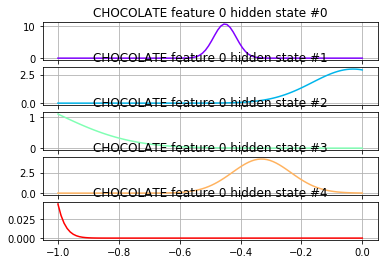

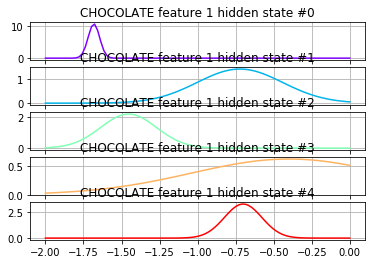

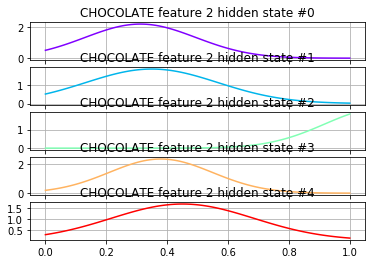

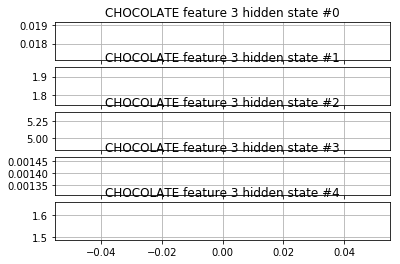

In [46]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [ ]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [86]:
from sklearn.model_selection import KFold
from asl_utils import combine_sequences

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds
    trainX, trainlengths = combine_sequences(cv_train_idx,word_sequences)
    testX, testlengths = combine_sequences(cv_test_idx,word_sequences)
    print(trainX,testX)

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
[[-20, 48, 26, 183], [-21, 46, 26, 183], [-20, 43, 30, 183], [-20, 43, 30, 183], [-18, 42, 32, 182], [-18, 38, 32, 178], [-15, 35, 35, 175], [-16, 36, 35, 175], [-14, 41, 35, 175], [-13, 38, 36, 172], [-13, 41, 36, 172], [-11, 39, 38, 170], [-16, 36, 38, 170], [-20, 36, -14, 126], [-22, 35, -14, 126], [-22, 35, -14, 126], [-21, 31, -14, 126], [-18, 30, -14, 126], [-15, 30, -14, 126], [-13, 30, -14, 126], [-13, 30, -14, 126], [-16, 28, -14, 126], [-16, 31, -14, 126], [-15, 33, -14, 126], [-15, 35, -14, 126], [-15, 35, -14, 126], [-16, 33, -14, 126], [-16, 33, -14, 126], [-16, 33, -14, 126], [-16, 33, -14, 126], [-19, 39, -11, 124], [-19, 39, -11, 124], [-19, 39, -11, 124], [-19, 39, -11, 124], [-16, 37, -11, 126], [-16, 37, -11, 126], [-16, 37, -11, 126], [-17, 34, -11, 126], [-20, 32, -11, 126], [-20, 32, -11, 126], [-20, 32, -11, 126], [-20, 32, -11, 126], [-20, 32, -11, 126], [-20, 32, -11, 126], [-18, 35, -9, 129], [-20, 31, -9, 1

**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [87]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [22]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

In [108]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

SelectorCV training on 2 sequences for word FISH
Word FISH Nstates 2 avg score -103248.52755549503
Word FISH Nstates 3 avg score -103248.52755549503
Couldn't score model for word FISH Nstates 4
Word FISH Nstates 4 avg score -146019.0047320989
Couldn't score model for word FISH Nstates 5
Word FISH Nstates 5 avg score -146019.0047320989
Couldn't score model for word FISH Nstates 6
Word FISH Nstates 6 avg score -145317.80076016625
Word FISH Nstates 7 avg score -79451.39748167744
Word FISH Nstates 8 avg score -71023.53362298693
Word FISH Nstates 9 avg score -64658.59721667424
Word FISH Nstates 10 avg score -59647.88890103546
Word FISH Nstates 11 avg score -55349.43913190529
Word FISH Nstates 12 avg score -73166.09122191233
Word FISH Nstates 13 avg score -68889.88099250094
Training complete for FISH with 11 states with time 1.013627625652589 seconds
SelectorCV training on 18 sequences for word BOOK
Word BOOK Nstates 2 avg score -896.2281150006032
Word BOOK Nstates 3 avg score -897.199557726

In [107]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

SelectorBIC training on 2 sequences for word FISH
Word FISH Nstates 2 BIC 272.03962798119363
Word FISH Nstates 3 BIC 24.706945538063337
Word FISH Nstates 4 BIC -13.888032822386862
Word FISH Nstates 5 BIC -55.86351326556533
Couldn't score model for word FISH Nstates 6
Couldn't score model for word FISH Nstates 7
Couldn't score model for word FISH Nstates 8
Couldn't score model for word FISH Nstates 9
Couldn't score model for word FISH Nstates 10
Couldn't score model for word FISH Nstates 11
Couldn't score model for word FISH Nstates 12
Couldn't score model for word FISH Nstates 13
Couldn't score model for word FISH Nstates 14
Couldn't score model for word FISH Nstates 15
Training complete for FISH with 5 states with time 0.865207943788846 seconds
SelectorBIC training on 18 sequences for word BOOK
Word BOOK Nstates 2 BIC 5053.991689460212
Word BOOK Nstates 3 BIC 4826.947448744671
Word BOOK Nstates 4 BIC 4805.948661036076
Word BOOK Nstates 5 BIC 4642.267977264342
Word BOOK Nstates 6 BIC 4

In [106]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

SelectorDIC training on 2 sequences for word FISH
Word FISH Nstates 2 DIC 63561.937089576204
Word FISH Nstates 3 DIC 12218224.905855525
Word FISH Nstates 4 DIC 85766.70892893402
Word FISH Nstates 5 DIC 230180.61413912007
Couldn't score model for word FISH Nstates 6
Couldn't score model for word FISH Nstates 7
Couldn't score model for word FISH Nstates 8
Couldn't score model for word FISH Nstates 9
Couldn't score model for word FISH Nstates 10
Couldn't score model for word FISH Nstates 11
Couldn't score model for word FISH Nstates 12
Couldn't score model for word FISH Nstates 13
Couldn't score model for word FISH Nstates 14
Couldn't score model for word FISH Nstates 15
Training complete for FISH with 3 states with time 1.9145925133343553 seconds
SelectorDIC training on 18 sequences for word BOOK
Word BOOK Nstates 2 DIC -99.42580480513334
Word BOOK Nstates 3 DIC 99.54290682303053
Word BOOK Nstates 4 DIC 1307.206031400803
Word BOOK Nstates 5 DIC 1545.3992274704883
Word BOOK Nstates 6 DIC 

**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:** At this stage in the notebook, one hasn't collected the actual performance of the selectors (in terms of accuracy and error rate), which is arguably the most important criterion. See test results at the bottom. One criterion we have now is training time. Both SelectorCV and Selector DIC take longer to train, while SelectorBIC is the fastest. This is because SelectorCV repeats training against multiple folds, and SelectorDIC scores all other words in the dictionary in order to determine discrimination power of each word's model. However, the difference in time is not prohibitively large, at least with this dataset.

Another criterion also arises from this dataset that impacts the SelectorCV: it can't train a model with just a single sample, and there are a lot of words in this dataset that have only one sample. I count 31 words out of 112, or more than a quarter of the words, with only one sample.

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [109]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

SelectorBIC training on 4 sequences for word FRANK
Word FRANK Nstates 2 BIC 902.2576985723875
Word FRANK Nstates 3 BIC 824.6592649804542
Word FRANK Nstates 4 BIC 806.4726034722559
Word FRANK Nstates 5 BIC 800.771112904695
Word FRANK Nstates 6 BIC 692.3521078463207
Word FRANK Nstates 7 BIC 697.5983897978441
Word FRANK Nstates 8 BIC 689.9894063492334
Word FRANK Nstates 9 BIC 742.1725764799975
Word FRANK Nstates 10 BIC 825.7043021780095
SelectorBIC training on 6 sequences for word VEGETABLE
Word VEGETABLE Nstates 2 BIC 887.2366839652452
Word VEGETABLE Nstates 3 BIC 876.7306244324642
Word VEGETABLE Nstates 4 BIC 862.9094974981311
Word VEGETABLE Nstates 5 BIC 879.1392044989014
Word VEGETABLE Nstates 6 BIC 861.2311458534002
Word VEGETABLE Nstates 7 BIC 890.4050583609005
Word VEGETABLE Nstates 8 BIC 856.3649348972358
Word VEGETABLE Nstates 9 BIC 874.5980273444363


.

Word VEGETABLE Nstates 10 BIC 1076.4161116810646


.

SelectorCV training on 113 sequences for word JOHN
Word JOHN Nstates 2 avg score -3103.013270833382
Word JOHN Nstates 3 avg score -3037.146349266517
Word JOHN Nstates 4 avg score -3044.915637923999
Word JOHN Nstates 5 avg score -2983.3882965761586
Word JOHN Nstates 6 avg score -2959.083470569946
Word JOHN Nstates 7 avg score -2907.7508257822906
Word JOHN Nstates 8 avg score -2946.3888472790463
Word JOHN Nstates 9 avg score -2942.6847741255515
Word JOHN Nstates 10 avg score -2947.5545189169957
SelectorCV training on 2 sequences for word CHICKEN
Word CHICKEN Nstates 2 avg score -218.38956168952683
Couldn't score model for word CHICKEN Nstates 3
Word CHICKEN Nstates 3 avg score -222.62654899170923
Couldn't score model for word CHICKEN Nstates 4
Word CHICKEN Nstates 4 avg score -796.04959096942
Couldn't score model for word CHICKEN Nstates 5
Word CHICKEN Nstates 5 avg score -2638.43542090799
Couldn't score model for word CHICKEN Nstates 6
Word CHICKEN Nstates 6 avg score -14351.56972260905

.


Couldn't score model for word CHICKEN Nstates 10
Word CHICKEN Nstates 10 avg score -14267.543242095004
SelectorDIC training on 37 sequences for word MARY
Word MARY Nstates 2 DIC -3318.7977681090288
Word MARY Nstates 3 DIC -3125.0552220861355
Word MARY Nstates 4 DIC -3030.0228462396726
Word MARY Nstates 5 DIC -2834.379243625014
Word MARY Nstates 6 DIC -2762.7464512302113
Word MARY Nstates 7 DIC -2587.5453996202546
Word MARY Nstates 8 DIC -2527.401226467783
Word MARY Nstates 9 DIC -2487.745885063539
Word MARY Nstates 10 DIC -2401.804567992006
SelectorDIC training on 1 sequences for word TOY
Word TOY Nstates 2 DIC 3194.3590214946726
Word TOY Nstates 3 DIC 8649.378178051844
Word TOY Nstates 4 DIC 6841.433587965607
Couldn't score model for word TOY Nstates 5
Couldn't score model for word TOY Nstates 6
Couldn't score model for word TOY Nstates 7
Couldn't score model for word TOY Nstates 8


.

Couldn't score model for word TOY Nstates 9
Couldn't score model for word TOY Nstates 10



----------------------------------------------------------------------
Ran 4 tests in 111.313s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [20]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models))) 

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [128]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [24]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [38]:
# TODO Choose a feature set and model selector
from my_model_selectors import *
features = features_custom_n2g # change as needed
model_selector = SelectorDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
#print(guesses)
show_errors(guesses, test_set)

SelectorDIC trained on 1 sequences for word HIT, bestnstates=6, score=15593.171338807602
SelectorDIC trained on 10 sequences for word YESTERDAY, bestnstates=10, score=2966.5960829014257
SelectorDIC trained on 1 sequences for word GET, bestnstates=6, score=17264.384584928903
SelectorDIC trained on 3 sequences for word HERE, bestnstates=8, score=13939.129504601131
SelectorDIC trained on 2 sequences for word BUT, bestnstates=9, score=23578.102094752012
SelectorDIC trained on 12 sequences for word GO, bestnstates=10, score=1556.8810875528784
SelectorDIC trained on 1 sequences for word PARTY, bestnstates=7, score=59658.63500176687
SelectorDIC trained on 5 sequences for word TELL, bestnstates=5, score=16989.43153735756
SelectorDIC trained on 1 sequences for word TOMORROW, bestnstates=8, score=12889.981865804843
SelectorDIC trained on 1 sequences for word LAST-WEEK, bestnstates=7, score=17706.272825649343
SelectorDIC trained on 17 sequences for word CAN, bestnstates=10, score=2502.35384087185

SelectorDIC trained on 3 sequences for word SELL, bestnstates=6, score=25115.96116711893
SelectorDIC trained on 5 sequences for word FINISH, bestnstates=10, score=3554.557650723278
SelectorDIC trained on 2 sequences for word BROCCOLI, bestnstates=6, score=15522.668590015512
SelectorDIC trained on 2 sequences for word SAY, bestnstates=2, score=48997.740454658495
SelectorDIC trained on 1 sequences for word CANDY, bestnstates=2, score=38253.72320335321
SelectorDIC trained on 4 sequences for word SUE, bestnstates=6, score=12181.754715440182
SelectorDIC trained on 2 sequences for word CHICKEN, bestnstates=10, score=13435.40841258221
SelectorDIC trained on 4 sequences for word PEOPLE, bestnstates=10, score=10843.176770960448
SelectorDIC trained on 1 sequences for word MANY, bestnstates=6, score=25154.869668609736
SelectorDIC trained on 2 sequences for word NEW-YORK, bestnstates=4, score=17715.605001665015
SelectorDIC trained on 1 sequences for word LEG, bestnstates=3, score=25361.30139224815

In [39]:
# TODO Choose a feature set and model selector
from my_model_selectors import *
features = features_custom_dn2g # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
#print(guesses)
show_errors(guesses, test_set)

Can't perform SelectorCV.select() with less than 2 sequences, word HIT
SelectorCV trained on 10 sequences for word YESTERDAY, bestnstates=3, avg score=117.21919611739553
Can't perform SelectorCV.select() with less than 2 sequences, word GET
SelectorCV trained on 3 sequences for word HERE, bestnstates=3, avg score=1.087843661875663
SelectorCV trained on 2 sequences for word BUT, bestnstates=2, avg score=18.97545832953205
SelectorCV trained on 12 sequences for word GO, bestnstates=4, avg score=-14.684987757389019
Can't perform SelectorCV.select() with less than 2 sequences, word PARTY
SelectorCV trained on 5 sequences for word TELL, bestnstates=3, avg score=44.46880195705675
Can't perform SelectorCV.select() with less than 2 sequences, word TOMORROW
Can't perform SelectorCV.select() with less than 2 sequences, word LAST-WEEK
SelectorCV trained on 17 sequences for word CAN, bestnstates=6, avg score=100.31240752405279
Can't perform SelectorCV.select() with less than 2 sequences, word TOY
C

SelectorCV trained on 2 sequences for word SAY, bestnstates=2, avg score=23.823083636274838
Can't perform SelectorCV.select() with less than 2 sequences, word CANDY
SelectorCV trained on 4 sequences for word SUE, bestnstates=4, avg score=98.33796246546076
SelectorCV trained on 2 sequences for word CHICKEN, bestnstates=3, avg score=72.78820021057572
SelectorCV trained on 4 sequences for word PEOPLE, bestnstates=3, avg score=11.963948817869065
Can't perform SelectorCV.select() with less than 2 sequences, word MANY
SelectorCV trained on 2 sequences for word NEW-YORK, bestnstates=2, avg score=49.97295034011752
Can't perform SelectorCV.select() with less than 2 sequences, word LEG
SelectorCV trained on 2 sequences for word STOLEN, bestnstates=4, avg score=-1.0456499368865835
SelectorCV trained on 5 sequences for word EAT, bestnstates=3, avg score=49.345460349406345
SelectorCV trained on 2 sequences for word MOVIE, bestnstates=2, avg score=18.275244001502056
Can't perform SelectorCV.select()

In [40]:
# TODO Choose a feature set and model selector
from my_model_selectors import *
features = features_custom_n2g_dn2g # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
#print(guesses)
show_errors(guesses, test_set)

SelectorBIC trained on 1 sequences for word HIT, bestnstates=2, score=-26.41268362844508
SelectorBIC trained on 10 sequences for word YESTERDAY, bestnstates=8, score=-618.5174967146037
SelectorBIC trained on 1 sequences for word GET, bestnstates=2, score=-21.776813230058252
SelectorBIC trained on 3 sequences for word HERE, bestnstates=3, score=-61.016213443225325
SelectorBIC trained on 2 sequences for word BUT, bestnstates=2, score=-36.199112007031914
SelectorBIC trained on 12 sequences for word GO, bestnstates=7, score=225.99839153219142
SelectorBIC trained on 1 sequences for word PARTY, bestnstates=2, score=-43.901354863003476
SelectorBIC trained on 5 sequences for word TELL, bestnstates=3, score=-352.78503525275084
SelectorBIC trained on 1 sequences for word TOMORROW, bestnstates=2, score=-106.40659895987581
SelectorBIC trained on 1 sequences for word LAST-WEEK, bestnstates=4, score=-0.8621650967962751
SelectorBIC trained on 17 sequences for word CAN, bestnstates=6, score=180.615653

SelectorBIC trained on 3 sequences for word SELL, bestnstates=3, score=-138.6785428458322
SelectorBIC trained on 5 sequences for word FINISH, bestnstates=4, score=64.17408914068369
SelectorBIC trained on 2 sequences for word BROCCOLI, bestnstates=3, score=-828.0209801512096
SelectorBIC trained on 2 sequences for word SAY, bestnstates=2, score=-201.2849884925252
SelectorBIC trained on 1 sequences for word CANDY, bestnstates=2, score=-161.47456397916835
SelectorBIC trained on 4 sequences for word SUE, bestnstates=4, score=-665.250098821309
SelectorBIC trained on 2 sequences for word CHICKEN, bestnstates=3, score=-338.42441340966235
SelectorBIC trained on 4 sequences for word PEOPLE, bestnstates=3, score=36.14337272689707
SelectorBIC trained on 1 sequences for word MANY, bestnstates=2, score=-63.58355276590345
SelectorBIC trained on 2 sequences for word NEW-YORK, bestnstates=2, score=-154.82437155648617
SelectorBIC trained on 1 sequences for word LEG, bestnstates=2, score=-128.12865368203

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:** I chose to run the custom features that I listed above, "n2g", "pn2g", "dn2g", and "n2g_dn2g". No one selector distinguished itself against all feature combinations. SelectorDIC gave the best error rate of WER=0.55 for the "n2g" features (shown first), but the other two selectors weren't far behind. The "polar_n2g" features performed worse than the other features across the board, and are not shown. SelectorCV performed best for the "dn2g" features with WER=0.573 (shown second).

It occurred to me that combining two sets of four features, namely the spatial information ("n2g") and the time information ("dn2g"), might perform better. This turned out to be the case. Both SelectorDIC and SelectorBIC (shown third) tied with a score of WER=0.489, and SelectorCV was close behind with a WER of 0.5.

This seems to say that feature engineering has a greater impact than which selector is used. In particular, if the dataset had fewer/no single sample words, SelectorCV might even have performed better than the other two. If I were to try to improve the WER further, I would explore a larger dataset as well as other features to add. One possible additional feature not available in the current dataset are the z coordinates of the hands, which may help for some words. Going further, one ought to explore the correlation of words beyond the immediately adjacent words.

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [125]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 74.446s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [ ]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()